In [19]:

from scipy import ndimage
import cv2
from sklearn.manifold import TSNE
import matplotlib.pyplot as plot

def vecToCSVLine(vector):
    line = ""
    for i, val in enumerate(vector):
        line += str(val)
        if i < len(vector) - 1:
            line += ", "
    line += "\n"
    return line

def CSVLineToVec(line):
    line_list = line.strip().replace("\n", "").split(",")
    float_list = []
    for i in line_list:
        float_list.append(float(i))
    float_list = np.array(float_list)
    return float_list

def oracleTriplet(p1, p2, p3):
    b_1, i1 = p1
    b_2, i2 = p2
    b_3, i3 = p3
    d12 = np.linalg.norm(b_1 - b_2)
    d23 = np.linalg.norm(b_2 - b_3)
    d31 = np.linalg.norm(b_3 - b_1)
    if d12 == min([d12, d23, d31]):
        trip = [i1, i2, i3]
    elif d23 == min([d12, d23, d31]):
        trip = [i2, i3, i1]
    else:
        trip = [i3, i1, i2]
    return trip

def train(ensemble, anchor_img, pos_img, neg_img, transform=True):
    if transform:
        pos_images = np.stack([
            [ndimage.rotate(pos_img, 90)],
            [ndimage.rotate(pos_img, 180)],
            [ndimage.rotate(pos_img, 270)],
        ])
    else:
        pos_images = np.array([[pos_img]])
    anchor_images = np.stack([[anchor_img] for _ in pos_images])
    neg_images = np.stack([[neg_img] for _ in pos_images])
    losses = ensemble.train_batch(anchor_images, pos_images, neg_images)
    return np.array(losses)

def train_batch(ensemble, anchor_batch, pos_batch, neg_batch, transform=True):
    losses = ensemble.train_batch(anchor_batch, pos_batch, neg_batch)
    return np.array(losses)

def visualize_projection(e):
    e.eval_mode()
    embeddings = []
    classes = []
    # for i in range(len(data)):
    for i in range(1000):
        image, _class = sampled_dataset[i][0], sampled_dataset[i][1][0]
        image = np.expand_dims(image, axis=0)
        embed = e.ensemble[0].forward(torch.tensor(image, device=device, dtype=torch.float))
        embed = embed.detach().cpu().squeeze(dim=0).numpy()
        embeddings.append(embed)
        classes.append(_class)

    embeddings = np.array(embeddings)

    reduced = TSNE(
        n_components=2,
        learning_rate="auto",
        init="pca",
        perplexity=40,
        early_exaggeration=1
    ).fit_transform(embeddings)

    color_classes = {
        -1: [0.33, 0.33, 0.33],
        0: [1, 0, 0],
        1: [0, 1, 0],
        2: [0, 0, 1],
        3: [0, 1, 1], # Cyan
        4: [1, 1, 0], # Yellow
        5: [0.5, 0, 0.25] # Pink
    }

    label_classes = {
        -1: "Unlabeled",
        0: "Random",
        1: "Cyclic Pursuit",
        2: "Milling",
        3: "Aggregation",
        4: "Dispersal",
        5: "Wall Following"
    }

    lim = len(reduced)
    classes = [-1 for i in range(lim)]

    OUT = "data/oracle"
    with open(os.path.join(OUT, "original-hand-labeled-classes.txt"), "r") as f:
        lines = f.readlines()
        for line in lines:
            triplet = CSVLineToVec(line)
            classes[int(triplet[0])] = int(triplet[1])

    x = [reduced[i][0] for i in range(lim)]
    y = [reduced[i][1] for i in range(lim)]
    colors = [color_classes[classes[i]] for i in range(lim)]
    labels = [label_classes[classes[i]] for i in range(lim)]
    plot.grid(True)
    # plot.xlim(-5000, 20000)
    # plot.ylim(-15000, 10000)
    plot.scatter(x, y, c=colors)
    plot.legend()
    plot.show()


In [4]:
import torch
import os
import numpy as np
from data.swarmset import ContinuingDataset, SwarmDataset
sampled_dataset = SwarmDataset("data/full-mini", rank=0)

DATA_TEST_SIZE = 1000
OUT = "data/oracle"

with open(os.path.join(OUT, "triplets.txt"), "w") as f:
    for i in range(DATA_TEST_SIZE):
        b = np.random.randint(len(sampled_dataset), size=3)
        a, p, n = b[0], b[1], b[2]
        b1, b2, b3 = sampled_dataset[b[0]][2], sampled_dataset[b[1]][2], sampled_dataset[b[2]][2]
        triplet = oracleTriplet((b1, a), (b2, p), (b3, n))
        f.write(vecToCSVLine(triplet))

Network 1, Accuracy: 72.55087553241836%
Network 2, Accuracy: 61.68954093705632%
Network 3, Accuracy: 67.27401798390913%
Pre-Query Validation Complete. Accuracy: 64.81306199716043%


/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


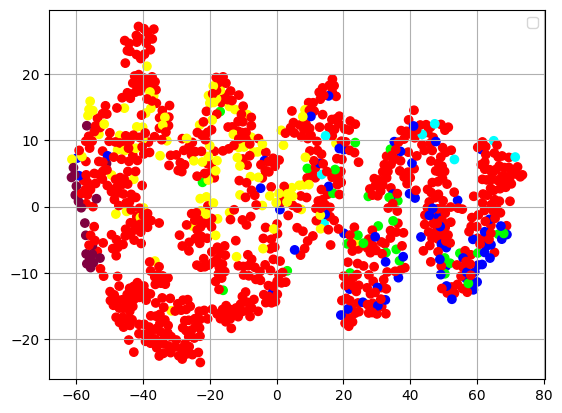

LR: [[0.0015], [0.0015], [0.0015]]
Epoch 0 Complete. Network Loss: [18.82486641 22.55628896 27.07568169]. Ensemble Loss: 22.818945686022442
Window Average Loss: 3.2598493837174916
LR: [[0.0015], [0.0015], [0.0015]]
Epoch 1 Complete. Network Loss: [17.64199567 18.3675046  18.78992009]. Ensemble Loss: 18.266473452250164
Window Average Loss: 5.8693455911818
LR: [[0.0015], [0.0015], [0.0015]]
Epoch 2 Complete. Network Loss: [16.45247483 15.46245837 13.51655889]. Ensemble Loss: 15.14383069674174
Window Average Loss: 8.03274997643062
LR: [[0.0015], [0.0015], [0.0015]]
Epoch 3 Complete. Network Loss: [15.50325823 13.5070858  10.20583749]. Ensemble Loss: 13.072060505549112
Window Average Loss: 9.900187191509065
LR: [[0.0015], [0.0015], [0.0015]]
Epoch 4 Complete. Network Loss: [14.50944185 12.45148182  7.93463778]. Ensemble Loss: 11.631853818893433
Window Average Loss: 11.561880594208128
LR: [[0.0015], [0.0015], [0.0015]]
Epoch 5 Complete. Network Loss: [13.68413258 11.60409164  6.28266168]. E

/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


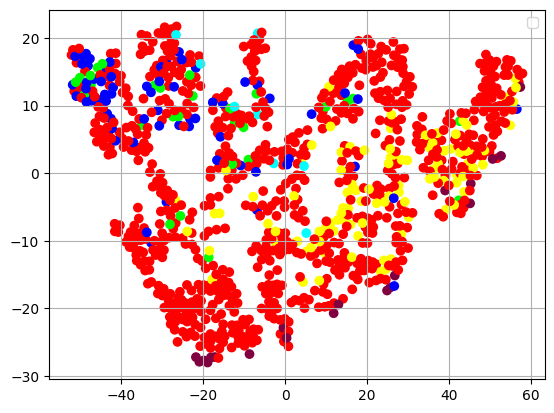

KeyboardInterrupt: 

In [25]:
import random
import torch
import os
import numpy as np
from networks.ensemble import Ensemble
from data.swarmset import ContinuingDataset, SwarmDataset
PRETRAINING = True
target = 0.0001
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ensembleA = Ensemble(size=3, output_size=5, lr=15e-4, learning_decay=0.9, decay_step=3, new_model=True, init=None)
ensembleA.load_ensemble("full-mini-r2")
# ensembleA.trim(3)

sampled_dataset = SwarmDataset("data/full-mini", rank=0)
data = sampled_dataset

total_queries = 0
validation_accuracy = []
per_network_acc = [[] for _ in ensembleA.ensemble]
overall_training_average = []


# Get initial Accuracy
# Validation on Oracle Dataset
validation_accuracy = []
OUT = "data/oracle"
with open(os.path.join(OUT, "Dec14-original-model-human-labeled.txt"), "r") as f:
    lines = f.readlines()
    total_score = 0
    network_score = np.array([0.0 for _ in ensembleA.ensemble])
    for line in lines:
        triplet = CSVLineToVec(line)
        majority, l = ensembleA.majority_belief(sampled_dataset[int(triplet[0])][0], sampled_dataset[int(triplet[1])][0], sampled_dataset[int(triplet[2])][0])
        bin_loss = []
        for i, loss in enumerate(l):
            bin_loss.append(l[i] < ensembleA.margin)
        network_score += np.array(bin_loss)
        total_score += majority
    acc = total_score / len(lines)
    net_acc = network_score / len(lines)

    for i, net in enumerate(net_acc):
        per_network_acc[i].append(net)
        print(f"Network {i + 1}, Accuracy: {net * 100}%")

    validation_accuracy.append(acc)
    print(f"Pre-Query Validation Complete. Accuracy: {acc * 100}%")
    visualize_projection(ensembleA)

TRIAL_SIZE = 50
training_triplets = []
pretraining_triplets = []
for global_epochs in range(TRIAL_SIZE):
    # Get Least Agreed Upon Triplets, then query the oracle
    SAMPLES = 50000
    rand_samp = [
        (random.randrange(0, len(data)), random.randrange(0, len(data)), random.randrange(0, len(data))) for i in range(SAMPLES)
    ]

    entropy = []
    for i in range(SAMPLES):
        ensembleA.eval_mode()
        h = ensembleA.variance(data[rand_samp[i][0]][0], positive=data[rand_samp[i][1]][0], negative=data[rand_samp[i][2]][0])
        entropy.append((h, i))
    entropy.sort(reverse=True)

    # Query the N most-disagreed upon Triplets
    QUERIES = 100
    N = min(SAMPLES, QUERIES)
    for i in range(N):
        # Generate UserTriplets
        samp_index = entropy[i][1]
        a, p, n = rand_samp[samp_index]
        b1, b2, b3 = data[a][2], data[p][2], data[n][2]
        triplet = oracleTriplet((b1, a), (b2, p), (b3, n))
        training_triplets.append(triplet)

        # Generate Pretraining Triplets
        a, n = rand_samp[i][0], rand_samp[i][2]
        pretraining_triplets.append([a, n])

    total_queries += N

    # Train on the training triplets for 5 epochs
    EPOCHS = 500 - (10 * global_epochs)
    CONTINUE_PRE = 0
    pretraining_counter = 0
    pretraining_max = 1000

    assert pretraining_max < SAMPLES

    training_losses = []
    for epoch in range(EPOCHS):
        ensembleA.training_mode()
        total_loss = [0.0 for _ in ensembleA.ensemble]
        pretraining_loss = [0.0 for _ in ensembleA.ensemble]
        updates = 0
        pre_updates = 0
        BATCH_SIZE = min(64, len(training_triplets) // 4)

        if BATCH_SIZE < CONTINUE_PRE:
            raise Exception("Invalid Config: Batch Size must be larger than the continue pretraining metric.")

        random.shuffle(training_triplets)
        for i in range(0, len(training_triplets), BATCH_SIZE - CONTINUE_PRE):
            anchors = []
            positives = []
            negatives = []
            if (i + BATCH_SIZE - CONTINUE_PRE) > len(training_triplets):
                break

            for j in range(BATCH_SIZE - CONTINUE_PRE):
                triplet = training_triplets[i + j]
                anchors.append(data[triplet[0]][0])
                positives.append(data[triplet[1]][0])
                negatives.append(data[triplet[2]][0])

            for l in range(CONTINUE_PRE):
                triplet = rand_samp[pretraining_counter % pretraining_max]
                anchors.append(data[triplet[0]][0])
                positives.append(ndimage.rotate(data[triplet[0]][0], 90))
                negatives.append(data[triplet[2]][0])
                pretraining_counter += 1

            assert len(anchors) == BATCH_SIZE, "Batch Size is inconsistent in code!"

            anchors = np.expand_dims(anchors, axis=1)
            positives = np.expand_dims(positives, axis=1)
            negatives = np.expand_dims(negatives, axis=1)
            total_loss += train_batch(ensembleA, np.array(anchors), np.array(positives), np.array(negatives))
            updates += 1

        lrs = ensembleA.evaluate_lr(total_loss / updates)
        print(f"LR: {lrs}")

        average_loss = sum(total_loss) / (len(ensembleA.ensemble) * updates)
        training_losses.append(average_loss)

        WINDOW_SIZE = 7
        window_average = sum(training_losses[-WINDOW_SIZE:]) / WINDOW_SIZE
        if len(training_losses) > WINDOW_SIZE and window_average < target:
            break
        print(f"Epoch {epoch} Complete. Network Loss: {total_loss / updates}. Ensemble Loss: {average_loss}")
        print(f"Window Average Loss: {window_average}")

    overall_training_average.append(sum(training_losses) / len(training_losses))

    # Validation on Oracle Dataset
    if global_epochs % 3 == 0 or global_epochs == TRIAL_SIZE - 1:
        ensembleA.eval_mode()
        OUT = "data/oracle"
        with open(os.path.join(OUT, "Dec14-original-model-human-labeled.txt"), "r") as f:
            lines = f.readlines()
            total_score = 0
            network_score = np.array([0.0 for _ in ensembleA.ensemble])
            for line in lines:
                triplet = CSVLineToVec(line)
                majority, l = ensembleA.majority_belief(sampled_dataset[int(triplet[0])][0], sampled_dataset[int(triplet[1])][0], sampled_dataset[int(triplet[2])][0])
                bin_loss = []
                for i, loss in enumerate(l):
                    bin_loss.append(l[i] < ensembleA.margin)
                network_score += np.array(bin_loss)
                total_score += majority
            acc = total_score / len(lines)
            net_acc = network_score / len(lines)

            print(f"Validation for Epoch: {global_epochs}, total_queries: {len(training_triplets)}")

            for i, net in enumerate(net_acc):
                per_network_acc[i].append(net)
                print(f"Network {i + 1}, Accuracy: {net * 100}%")

            validation_accuracy.append(acc)
            print(f"Validation Complete. Accuracy: {acc * 100}%")
            visualize_projection(ensembleA)

    ensembleA.set_lr(15e-4, 0.95)

In [4]:
len(training_triplets)

4500

In [26]:
import time
ensembleA.save_ensemble(f"{int(time.time())}")

[0.6039603960396039, 0.6247524752475248, 0.6316831683168317, 0.6346534653465347, 0.6227722772277228, 0.6079207920792079]


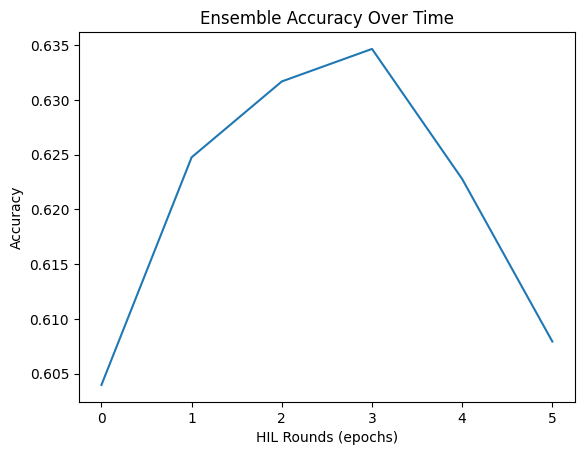

[0.9132341270285208, 0.43415493160146473, 0.33318362979177296, 0.3712153183767196, 0.40065383167159085]


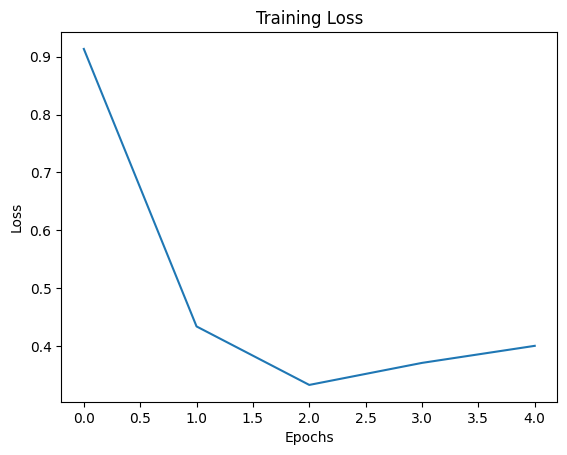

[[0.6108910891089109, 0.6247524752475248, 0.6465346534653466, 0.6465346534653466, 0.6326732673267327, 0.6138613861386139], [0.601980198019802, 0.5752475247524752, 0.597029702970297, 0.6148514851485148, 0.6118811881188119, 0.602970297029703], [0.598019801980198, 0.6128712871287129, 0.597029702970297, 0.6118811881188119, 0.595049504950495, 0.594059405940594]]


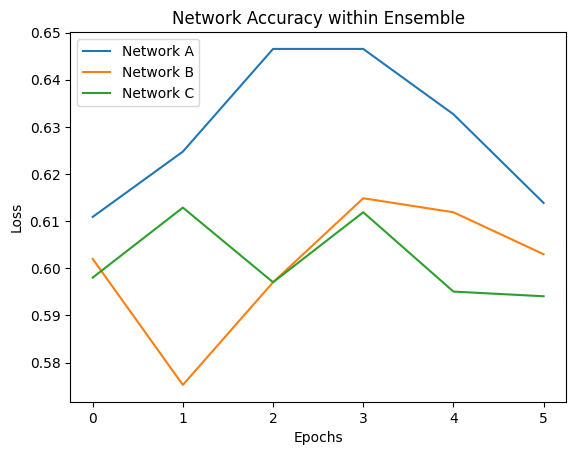

In [15]:
import matplotlib.pyplot as plot
print(validation_accuracy)
plot.plot(validation_accuracy)
plot.title("Ensemble Accuracy Over Time")
plot.ylabel("Accuracy")
plot.xlabel("HIL Rounds (epochs)")
plot.show()

print(overall_training_average)
plot.plot(overall_training_average)
plot.title("Training Loss")
plot.ylabel("Loss")
plot.xlabel("Epochs")
plot.show()

print(per_network_acc)
plot.plot(per_network_acc[0], label="Network A")
plot.plot(per_network_acc[1], label="Network B")
plot.plot(per_network_acc[2], label="Network C")
plot.title("Network Accuracy within Ensemble")
plot.ylabel("Loss")
plot.xlabel("Epochs")
plot.legend()

In [27]:
import random
import torch
import os
import numpy as np
from networks.ensemble import Ensemble
from data.swarmset import ContinuingDataset, SwarmDataset
PRETRAINING = True
target = 0.01
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ensembleA = Ensemble(size=5, output_size=5, lr=6e-4, learning_decay=0.95, decay_step=3)
ensembleA.load_ensemble("Nov21-subzerofive")
ensembleA.trim(1)

sampled_dataset = SwarmDataset("data/full-dual-sensors", rank=0)
data = sampled_dataset

total_queries = 0
validation_accuracy = [0.6039603960396039]
per_network_acc = [[] for _ in ensembleA.ensemble]
overall_training_average = []


# Get initial Accuracy
# Validation on Oracle Dataset
validation_accuracy = []
OUT = "data/oracle"
with open(os.path.join(OUT, "Nov21-Triplets.txt"), "r") as f:
    lines = f.readlines()
    total_score = 0
    network_score = np.array([0.0 for _ in ensembleA.ensemble])
    for line in lines:
        triplet = CSVLineToVec(line)
        majority, l = ensembleA.majority_belief(sampled_dataset[int(triplet[0])][0], sampled_dataset[int(triplet[1])][0], sampled_dataset[int(triplet[2])][0])
        bin_loss = []
        for i, loss in enumerate(l):
            bin_loss.append(l[i] == 0.0)
        network_score += np.array(bin_loss)
        total_score += majority
    acc = total_score / len(lines)
    net_acc = network_score / len(lines)

    for i, net in enumerate(net_acc):
        per_network_acc[i].append(net)
        print(f"Network {i + 1}, Accuracy: {net * 100}%")

    validation_accuracy.append(acc)
    print(f"Pre-Query Validation Complete. Accuracy: {acc * 100}%")

TRIAL_SIZE = 10
training_triplets = []
pretraining_triplets = []
for global_epochs in range(TRIAL_SIZE):
    # Get Least Agreed Upon Triplets, then query the oracle
    SAMPLES = 4000
    rand_samp = [
        (random.randrange(0, len(data)), random.randrange(0, len(data)), random.randrange(0, len(data))) for i in range(SAMPLES)
    ]

    # Query the N most-disagreed upon Triplets
    N = min(SAMPLES, 25)
    for i in range(N):
        # Generate UserTriplets
        a, p, n = rand_samp[i]
        b1, b2, b3 = data[a][2], data[p][2], data[n][2]
        triplet = oracleTriplet((b1, a), (b2, p), (b3, n))
        training_triplets.append(triplet)

        # Generate Pretraining Triplets
        a, n = rand_samp[i][0], rand_samp[i][2]
        pretraining_triplets.append([a, n])

    total_queries += N

    # Train on the training triplets for 5 epochs
    EPOCHS = 500
    CONTINUE_PRE = 2
    pretraining_counter = 0
    pretraining_max = 1200

    assert pretraining_max < SAMPLES

    training_losses = []
    for epoch in range(EPOCHS):
        ensembleA.training_mode()
        total_loss = [0.0 for _ in ensembleA.ensemble]
        pretraining_loss = [0.0 for _ in ensembleA.ensemble]
        updates = 0
        pre_updates = 0
        BATCH_SIZE = 4

        if BATCH_SIZE < CONTINUE_PRE:
            raise Exception("Invalid Config: Batch Size must be larger than the continue pretraining metric.")

        random.shuffle(training_triplets)
        for i in range(0, len(training_triplets), BATCH_SIZE - CONTINUE_PRE):
            anchors = []
            positives = []
            negatives = []
            if (i + BATCH_SIZE - CONTINUE_PRE) > len(training_triplets):
                break

            for j in range(BATCH_SIZE - CONTINUE_PRE):
                triplet = training_triplets[i + j]
                anchors.append(data[triplet[0]][0])
                positives.append(data[triplet[1]][0])
                negatives.append(data[triplet[2]][0])

            for l in range(CONTINUE_PRE):
                triplet = rand_samp[pretraining_counter % pretraining_max]
                anchors.append(data[triplet[0]][0])
                positives.append(ndimage.rotate(data[triplet[0]][0], 90))
                negatives.append(data[triplet[2]][0])
                pretraining_counter += 1

            assert len(anchors) == BATCH_SIZE, "Batch Size is inconsistent in code!"

            anchors = np.expand_dims(anchors, axis=1)
            positives = np.expand_dims(positives, axis=1)
            negatives = np.expand_dims(negatives, axis=1)
            total_loss += train_batch(ensembleA, np.array(anchors), np.array(positives), np.array(negatives))
            updates += 1

        lrs = ensembleA.evaluate_lr(total_loss / updates)
        print(f"LR: {lrs}")

        average_loss = sum(total_loss) / (len(ensembleA.ensemble) * updates)
        training_losses.append(average_loss)

        WINDOW_SIZE = 7
        window_average = sum(training_losses[-WINDOW_SIZE:]) / WINDOW_SIZE
        if len(training_losses) > WINDOW_SIZE and window_average < 0.01:
            break
        print(f"Epoch {epoch} Complete. Network Loss: {total_loss / updates}. Ensemble Loss: {average_loss}")
        print(f"Window Average Loss: {window_average}")

    overall_training_average.append(sum(training_losses) / len(training_losses))

    # Validation on Oracle Dataset
    ensembleA.eval_mode()
    OUT = "data/oracle"
    with open(os.path.join(OUT, "Nov21-Triplets.txt"), "r") as f:
        lines = f.readlines()
        total_score = 0
        network_score = np.array([0.0 for _ in ensembleA.ensemble])
        for line in lines:
            triplet = CSVLineToVec(line)
            majority, l = ensembleA.majority_belief(sampled_dataset[int(triplet[0])][0], sampled_dataset[int(triplet[1])][0], sampled_dataset[int(triplet[2])][0])
            bin_loss = []
            for i, loss in enumerate(l):
                bin_loss.append(l[i] == 0.0)
            network_score += np.array(bin_loss)
            total_score += majority
        acc = total_score / len(lines)
        net_acc = network_score / len(lines)

        for i, net in enumerate(net_acc):
            per_network_acc[i].append(net)
            print(f"Network {i + 1}, Accuracy: {net * 100}%")

        validation_accuracy.append(acc)
        print(f"Validation Complete. Accuracy: {acc * 100}%")

    ensembleA.set_lr(5e-4, 0.95)

KeyboardInterrupt: 

[0.598019801980198, 0.5841584158415841, 0.6039603960396039, 0.6039603960396039, 0.6158415841584158]


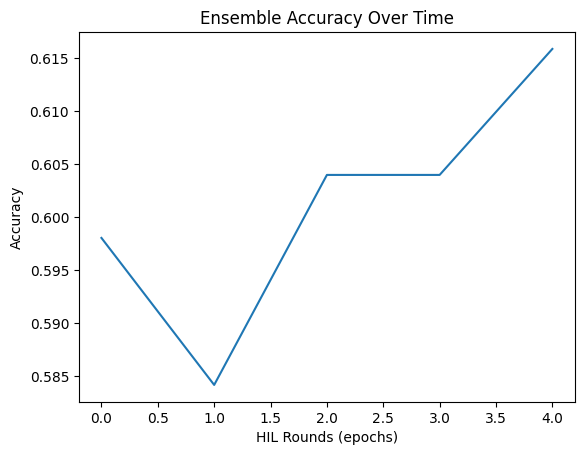

[2.1089120544693056, 0.5679879749050949, 0.45089953921854875, 0.24677202485961866]


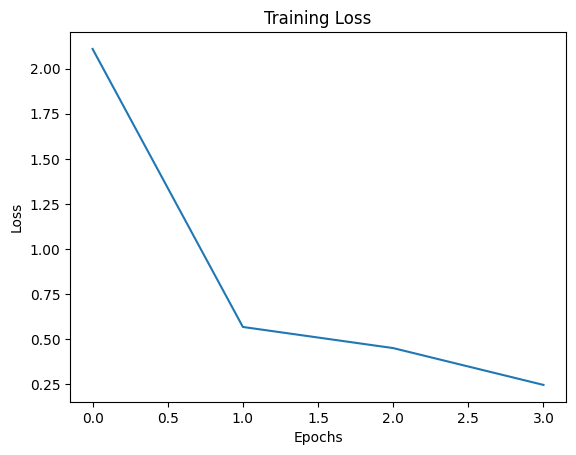

[[0.598019801980198, 0.5841584158415841, 0.6039603960396039, 0.6039603960396039, 0.6158415841584158]]


IndexError: list index out of range

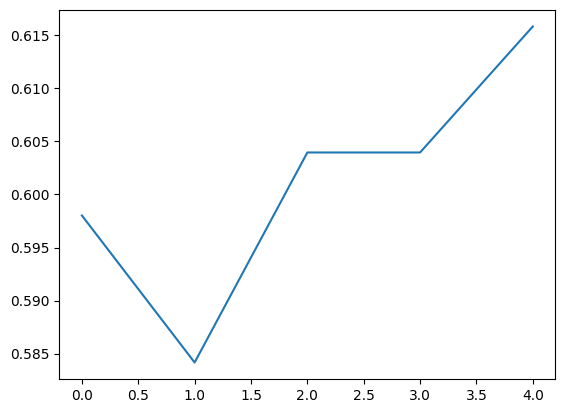

In [18]:
import matplotlib.pyplot as plot
print(validation_accuracy)
plot.plot(validation_accuracy)
plot.title("Ensemble Accuracy Over Time")
plot.ylabel("Accuracy")
plot.xlabel("HIL Rounds (epochs)")
plot.show()

print(overall_training_average)
plot.plot(overall_training_average)
plot.title("Training Loss")
plot.ylabel("Loss")
plot.xlabel("Epochs")
plot.show()

print(per_network_acc)
plot.plot(per_network_acc[0], label="Network A")
plot.plot(per_network_acc[1], label="Network B")
plot.plot(per_network_acc[2], label="Network C")
plot.title("Network Accuracy within Ensemble")
plot.ylabel("Loss")
plot.xlabel("Epochs")
plot.legend()

In [12]:
# Obtain info on No Training Model

import random
import torch
import os
import numpy as np
from networks.ensemble import Ensemble
from data.swarmset import ContinuingDataset, SwarmDataset

PRETRAINING = True
target = 0.01
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ensemble_random = Ensemble(size=1, output_size=5, lr=6e-4, learning_decay=0.95, decay_step=3, init="Random", new_model=True)
ensemble_random.load_ensemble("full-mini-SIMCLR-3")
sampled_dataset = SwarmDataset("data/full-mini", rank=0)
data = sampled_dataset

total_queries = 0
validation_accuracy = []
per_network_acc = [[] for _ in ensemble_random.ensemble]
overall_training_average = []

# Get initial Accuracy
# Validation on Oracle Dataset
OUT = "data/oracle"
with open(os.path.join(OUT, "Dec3-Original-Mini.txt"), "r") as f:
    lines = f.readlines()
    total_score = 0
    network_score = np.array([0.0 for _ in ensemble_random.ensemble])
    for line in lines:
        triplet = CSVLineToVec(line)
        majority, l = ensemble_random.majority_belief(sampled_dataset[int(triplet[0])][0], sampled_dataset[int(triplet[1])][0], sampled_dataset[int(triplet[2])][0])
        bin_loss = []
        for i, loss in enumerate(l):
            bin_loss.append(l[i] < 10.0)
        network_score += np.array(bin_loss)
        total_score += majority
    acc = total_score / len(lines)
    net_acc = network_score / len(lines)

    for i, net in enumerate(net_acc):
        per_network_acc[i].append(net)
        print(f"Network {i + 1}, Accuracy: {net * 100}%")

    validation_accuracy.append(acc)
    print(f"Pre-Query Validation Complete. Accuracy: {acc * 100}%")

Network 1, Accuracy: 52.2%
Pre-Query Validation Complete. Accuracy: 52.2%


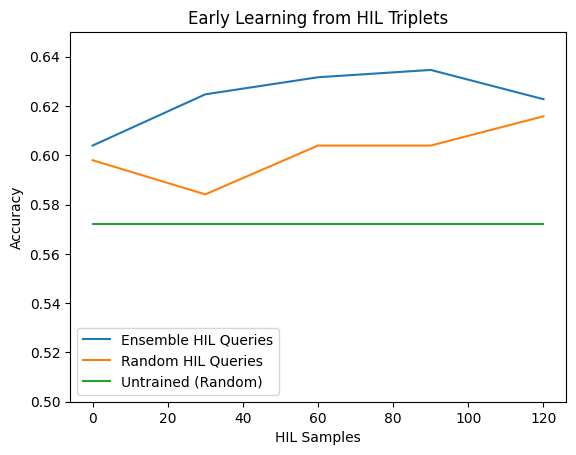

In [26]:
import matplotlib.pyplot as plot
hil_ensemble = [0.603960396,	0.6247524752,	0.6316831683,	0.6346534653,	0.6227722772]
hil_random = [0.598019802,	0.5841584158415841,	0.603960396,	0.603960396,	0.6158415842]
untrained = [0.572277, 0.572277, 0.572277, 0.572277, 0.572277]
hil_samples = [i * 30 for i in range(len(hil_ensemble))]

plot.ylim([0.5, 0.65])
plot.plot(hil_samples, hil_ensemble, label="Ensemble HIL Queries")
plot.plot(hil_samples, hil_random, label="Random HIL Queries")
plot.plot(hil_samples, untrained, label="Untrained (Random)")
plot.title("Early Learning from HIL Triplets")
plot.ylabel("Accuracy")
plot.xlabel("HIL Samples")
plot.legend()

plot.show()